### 目录
 
 - 准备模型开发环境
 - 生成验证码数据集
 - 输入与输出数据处理
 - 模型结构设计
 - 模型损失函数设计
 - 模型训练过程分析
 - 模型部署与效果演示

### 一、准备模型开发环境

**1.第三方依赖包**

```
pip install Pillow captcha pydot flask

```

**2.Pillow(PUL Fork)**

`PIL(Python Imaging Library)`为Python解释器添加了图像处理功能。但是，在2009年发布1.17版本之后，社区便停止更新和维护。

`Pillow`是由Alex Clark及社区贡献者一起开发和维护的一款分叉自`PIL`的图像工具库。至今，社区依然非常活跃，`Pillow`仍在快速迭代。

`Pillow`提供广泛的文件格式支持，高效的内部表示和相当强大的图像处理功能。核心图像库旨在快速访问以几种基本像素格式存储的数据，它应该为一般的图像处理工具提供坚实的基础。

**3.catpcha**

`Catpcha`是一个生成图像和音频验证码的开源工具库

```
from captcha.image import ImageCaptcha
from captcha.audio import AudioCaptcha

image = ImageCaptcha(fonts=["/path/A.ttf","/path/B.ttf")
data = image.generate("1234")
image.write("1234","out.png")

audio = AudioCaptcha(voicedir="/path/voices")
data = audio.generate("1234")
audio.write("1234","out.wav")
```

**4.pydot**

`pydot`是用纯`Python`实现的`GraphViz`接口，支持使用`GraphViz`解析和存储`DOT`语言(graph description language).其主要依赖`pyparsing`和`GraphViz`这两个工具库

`pyparsing`:仅用于加载`DOT`文件，在`pydot`安装期间自动安装。

`Graphviz`:将图形渲染为PDF，PNG,SVG等格式文件，需独立安装。

**5.flask**

`flask`是一个基于Werkzeug和jinja2开发的Python Web应用程序框架，遵从`BSD`开源协议。它以一种简约的方式实现了框架核心，又保留了扩展性。

### 二、生成验证码数据集

**1.验证码（catpcha）简介**

全自动区分计算机和人类对的公开图灵测试，俗称验证码，是`一种区分用户是计算机或人的公共全自动程序`。在captcha测试中，作为服务器的计算机会自动生成一个问题由用户来解答。这个问题可以由计算机生成并评判，但是必须只有人类才能解答。由于计算机无法解答captcha的问题，所以回答出问题的用户就可以被认为是人类。

一种常用的captcha测试是`让用户输入一个扭曲变形的图片上所显示的文字或数字`，扭曲变形式为了避免被光学字符识别（OCR）之类的计算机程序自动识别出图片上的数字而失去效果。由于这个测试是由计算机来考人类，而不是标准图灵测试中那样由人类来考计算机，人们有时称captcha是一种`反向图灵测试`。

**2.验证码的演进**

**3.验证码的生成**

**a.引入第三方包**

In [1]:
from captcha.image import ImageCaptcha

import random 
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import matplotlib.pyplot as plt
import PIL.Image as Image

**b.定义常量和字符集**

In [2]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
           'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   # 验证码字符集
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160        # 验证码宽度

TRAIN_DATASET_SIZE = 5000  # 验证码数据集大小
TEST_DATASET_SIZE = 1000   # 验证码测试集大小
TRAIN_DATA_DIR = "./train-data/" # 验证码数据集目录
TEST_DATA_DIR = "./test-data/"   # 验证码测试集目录

**c.生成随机字符的方法**

In [3]:
def gen_random_text(charset=CAPTCHA_CHARSET,length=CAPTCHA_LEN):
    text = [random.choice(charset) for _ in range(length)]
    return "".join(text)

**d.创建并保存验证码数据集的方法**

In [4]:
def create_captcha_dataset(size=100,data_dir="./data/",height=60,width=160,image_format=".png"):
    
    # 如果保存验证码图像，先清空data_dir目录
    # if gfile.Exists(data_dir):
    #     gfile.DeleteRecursively(data_dir)
    # gfile.MakeDirs(data_dir)
    
    # 创建ImageCaptcha实例captcha
    captcha = ImageCaptcha(width=width,height=height)
    
    for _ in range(size):
        # 生成随机的验证码字符
        text = gen_random_text(CAPTCHA_CHARSET,CAPTCHA_LEN)
        captcha.write(text,data_dir + text + image_format)
    
    return None

**e.创建并保存训练集及测试集**

In [5]:
# 创建并保存训练集
create_captcha_dataset(TRAIN_DATASET_SIZE,TRAIN_DATA_DIR)

# 创建并保存测试集
create_captcha_dataset(TEST_DATASET_SIZE,TEST_DATA_DIR)

**f.生成并返回验证码数据集的方法**

In [6]:
def gen_captcha_dataset(size=100,height=60,width=160,image_font=".png"):
    
    # 创建ImageCaptcha实例captcha
    captcha = ImageCaptcha(width=width,height=height)
    
    # 创建图像和文本数组
    images,texts = [None]*size,[None]*size
    for i in range(size):
        # 生成随机的验证码字符
        texts[i] = gen_random_text(CAPTCHA_CHARSET,CAPTCHA_LEN)
        # 使用PIL.Image.open() 识别新生成的验证码图像
        # 然后，将图像转换为形如(CAPTCHA_WIDTH,CAPTCHA_HEIGHT,3)的numpy数组
        images[i] = np.array(Image.open(captcha.generate(texts[i]))) 
        
    return images,texts

**g.生成100张验证码图像和字符**

In [7]:
# 生成并返回图像和标签
images,texts = gen_captcha_dataset()

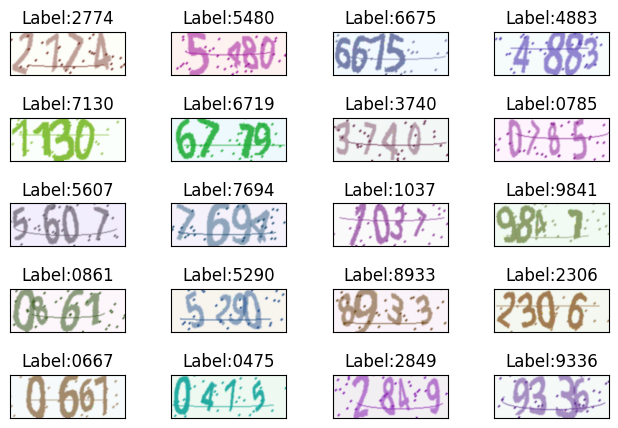

In [8]:
# 展示
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1) # 绘制前20个验证码，以5行4列子图形式展示
    plt.tight_layout()   # 自动适配子图尺寸
    plt.imshow(images[i])
    plt.title("Label:{}".format(texts[i])) # 设置标签为子图标题
    plt.xticks([])       # 删除x轴标记
    plt.yticks([])       # 删除y轴标记
plt.show()

### 三、输入与输出数据处理

**1.输入数据处理**

**2.输出数据处理**

**3.数据处理**

**a.引入第三方包**

In [9]:
from PIL import Image
from keras import backend as K

import random
import glob

import numpy as np

import matplotlib.pyplot as plt

**b.定义超参数和字符集**

In [10]:
NUMBER = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
LOWERCASE = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
            'v', 'w', 'x', 'y', 'z']
UPPERCASE = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U',
           'V', 'W', 'X', 'Y', 'Z']

CAPTCHA_CHARSET = NUMBER   # 验证码字符集
CAPTCHA_LEN = 4            # 验证码长度
CAPTCHA_HEIGHT = 60        # 验证码高度
CAPTCHA_WIDTH = 160        # 验证码宽度

TRAIN_DATA_DIR = '.\\train-data\\' # 验证码数据集目录

**c.读取训练集前100张图片，并通过文件名解析验证码(标签)**

In [11]:
image = []
text = []
count = 0
for filename in glob.glob(TRAIN_DATA_DIR + "*.png"):
    image.append(np.array(Image.open(filename)))
    text.append(filename.lstrip(TRAIN_DATA_DIR).rstrip(".png"))
    count +=  1
    if count >= 100:
        break

**d.数据可视化**

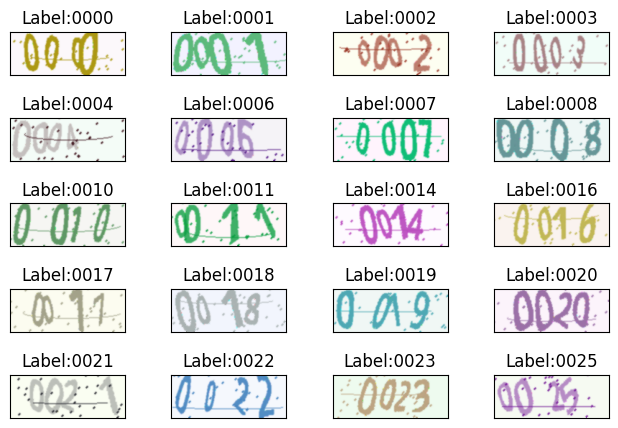

In [12]:
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1) # 绘制前20个验证码，以5行4列子图形式展示
    plt.tight_layout()   # 自动适配子图尺寸
    plt.imshow(image[i])
    plt.title("Label:{}".format(text[i])) # 设置标签为子图标题
    plt.xticks([])       # 删除x轴标记
    plt.yticks([])       # 删除y轴标记
plt.show()

In [13]:
image = np.array(image,dtype=np.float32)
print(image.shape,type(image))

(100, 60, 160, 3) <class 'numpy.ndarray'>


**e.将RGB验证码图像转成灰度图**

In [14]:
# 定义转灰度图函数
def rgb2gray(img):
    # 这里利用公式来转换 Y' = 0.299 R + 0.587 G + 0.114 B 
    return np.dot(img[...,:3],[0.299,0.587,0.114])

# 转换
image = rgb2gray(image)
# 输出维度
print(image.shape)

(100, 60, 160)


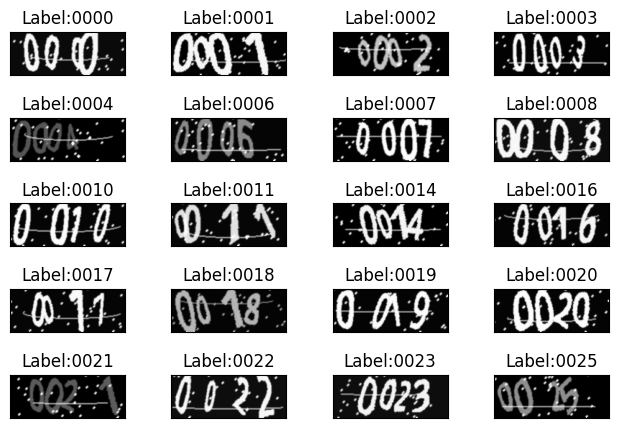

In [15]:
# 查看图形
plt.figure()
for i in range(20):
    plt.subplot(5,4,i+1)  # 绘制前20个验证码，以5行4列子图形式展示
    plt.tight_layout()    # 自动适配子图尺寸
    plt.imshow(image[i],cmap="Greys")
    plt.title("Label:{}".format(text[i])) # 设置标签为子图标题
    plt.xticks([])        # 删除x轴标记
    plt.yticks([])        # 删除y轴标记
plt.show()

**f.数据规范化**

In [16]:
image = image / 255
image[0]

array([[0.97858039, 0.97858039, 0.97858039, ..., 0.97858039, 0.97858039,
        0.97858039],
       [0.97858039, 0.97858039, 0.97858039, ..., 0.97858039, 0.97858039,
        0.97858039],
       [0.97858039, 0.97858039, 0.97858039, ..., 0.97858039, 0.97858039,
        0.97858039],
       ...,
       [0.97858039, 0.97858039, 0.97858039, ..., 0.97858039, 0.97858039,
        0.97858039],
       [0.97858039, 0.97858039, 0.97858039, ..., 0.97858039, 0.97858039,
        0.97858039],
       [0.97858039, 0.97858039, 0.97858039, ..., 0.97858039, 0.97858039,
        0.97858039]])

**g.适配Keras图像数据格式**

In [17]:
# 先查看一下数据的维度
print(image.shape,type(image))

(100, 60, 160) <class 'numpy.ndarray'>


In [18]:
# 定义适配函数 hdf5格式
def fit_keras_channels(batch,rows=CAPTCHA_HEIGHT,cols=CAPTCHA_WIDTH):
    if K.image_data_format() == "channels_first":
        batch = batch.reshape(batch.shape[0],1,rows,cols)
        input_shape = (1,rows,cols)
    else:
        batch = batch.reshape(batch.shape[0],rows,cols,1)
        input_shape = (rows,cols,1)
    
    return batch,input_shape

In [19]:
# 再重新查看一下数据的维度
image,input_shape = fit_keras_channels(image)
print(image.shape,type(image))
print(input_shape)

(100, 60, 160, 1) <class 'numpy.ndarray'>
(60, 160, 1)


**h.对验证按中每个字符进行one-hot编码**

In [20]:
# 查看一下text中的数据
print(text[:10])
print(len(text[0]))
print(len(text))

['0000', '0001', '0002', '0003', '0004', '0006', '0007', '0008', '0010', '0011']
4
100


In [21]:
# 定义one-hot编码函数  将离散数据转换成向量
# CAPTCHA_CHARSET = NUMBER   # 验证码字符集
# CAPTCHA_LEN = 4            # 验证码长度
def text2vec(text,length=CAPTCHA_LEN,charset=CAPTCHA_CHARSET):
    text_len = len(text)
    # 验证码长度校验
    if text_len != length:
        raise ValueError("Error:length of captcha should be{},but got {}".format(length,text_len))
    # 生成一个形如(CAPTCHA_LEN*CAPTCHA_CHARSET)的一维向量
    # 例如，4个纯数字的验证码生成形如(4*10,)的一维向量
    vec = np.zeros(length*len(charset))
    for i in range(length):
        # One-hot编码验证码中的每个数字
        # 每个字符的热码 = 索引 +偏移量
        vec[charset.index(text[i]) + i*len(charset)] = 1
    return vec

In [22]:
text = list(text)
vec = [None]*len(text)

for i in range(len(vec)):
    vec[i] = text2vec(text[i])

In [23]:
print(text[0])
print(vec[0])

0000
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
